# Tarea 2 - Taller de Deep Learning

**Fecha de entrega: 16/11/2025**  
**Puntaje máximo: 15**

## Introducción

El objetivo de esta tarea es evaluar su capacidad para aplicar modelos de redes neuronales recurrentes (RNN/LSTM/GRU) en un problema de clasificación de secuencias. En particular, vamos a evaluar la performance de sus modelos en la clasificación de ritmos cardíacos usando datos de electrocardiograma (ECG).

**Dataset**

El dataset a ser utilizado es el [Heartbeat Dataset](https://www.kaggle.com/datasets/shayanfazeli/heartbeat). Este dataset contiene señales de ECG segmentadas, donde cada segmento corresponde a un latido del corazón. Cada segmento ya está preprocesado y categorizado en una de las siguientes clases:

- **N**: Normal (0)
- **S**: Arritmia supraventricular (1)
- **V**: Arritmia ventricular (2)
- **F**: Latido fusionado (3)
- **Q**: Latido desconocido (4)

Los archivos del dataset que deben utilizar son:

- **mitbih_train.csv**: Datos de entrenamiento.
- **mitbih_test.csv**: Datos de prueba.

**Tarea**

Tienen total libertad sobre cómo implementar y resolver el problema, así como las técnicas y herramientas que quieran usar. Se recomienda el uso de Google Colab para simplificar el acceso a recursos de GPU, aunque pueden trabajar en sus propias máquinas si lo prefieren. La entrega debe realizarse en formato .ipynb (Jupyter Notebook) **con las celdas ya ejecutadas**.

**Restricciones**

- No se permite utilizar modelos pre-entrenados; cada modelo debe ser implementado desde cero.
- Deben utilizar al menos un modelo basado en RNN (por ejemplo, LSTM o GRU).
- Es necesario realizar un **análisis exploratorio de los datos**, que incluya una descripción de las señales ECG, el balanceo de clases y cualquier limpieza o transformación necesaria de los datos.
- Las decisiones sobre el preprocesamiento de las señales (como normalización, segmentación, etc.) deben estar fundamentadas en una exploración inicial del dataset y explicadas en el notebook.

**Reporte**

Se requiere que reporten las siguientes métricas: accuracy, precision, recall y F1-score para la evaluación del modelo. Además, se espera ver una evolución clara del modelo durante el entrenamiento, que incluya logs y gráficas de las métricas tanto para los datos de entrenamiento como de validación.

**Evidencia de Experimentos**

Deben proporcionar evidencia de la ejecución de experimentos usando [Weights & Biases (wandb)](https://wandb.ai/). Esto incluye:

- Registros detallados de los experimentos.
- Gráficas y logs de entrenamiento.
- Comparaciones entre diferentes configuraciones de modelos.

In [8]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pydantic")
import numpy as np
import torch
import random
from tqdm import tqdm
from pathlib import Path
import copy
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import wandb
import kagglehub
from datasets import load_dataset
from Utils import train_w_early_stopping

In [9]:
data_files = {
    "train": "data/mitbih_train.csv",
    "test": "data/mitbih_test.csv"
}

## 1. Exploración del set de datos

In [10]:
df_train = pd.read_csv(data_files["train"], header=None)

df_test = pd.read_csv(data_files["test"], header=None)

X_train_raw = df_train.iloc[:, :-1].values.astype(np.float32)
y_train = df_train.iloc[:, -1].values.astype(int)
X_test_raw  = df_test.iloc[:, :-1].values.astype(np.float32)
y_test  = df_test.iloc[:, -1].values.astype(int)

#### **Armo un set de validación**
Para poder usar early stopping y evaluar hiperparámetros

In [11]:
X_train_full = X_train_raw
y_train_full = y_train

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,
    random_state=42,
    stratify=y_train_full
)

#### **Evaluó características del set de datos**

In [12]:
print(f"Total ECGs recolectados: {len(df_train) + len(df_test)}")
print(f"Total datos en train: {len(df_train)}")
print(f"Total datos en test: {len(df_test)}")
train_counts = pd.Series(y_train).value_counts().sort_index()
test_counts  = pd.Series(y_test).value_counts().sort_index()
print("\n---- Conteo por clase en datos de train----")
print(train_counts)
print("\n---- Conteo por clase en datos de test----")
print(test_counts)
print("\n---- Largo de los segmentos de ECG ----")
print(len(X_train_raw[0]))


Total ECGs recolectados: 109446
Total datos en train: 87554
Total datos en test: 21892

---- Conteo por clase en datos de train----
0    57977
1     1778
2     4630
3      513
4     5145
Name: count, dtype: int64

---- Conteo por clase en datos de test----
0    18118
1      556
2     1448
3      162
4     1608
Name: count, dtype: int64

---- Largo de los segmentos de ECG ----
187


#### **Distribución de las clases**

C:\Users\Octav\AppData\Local\Temp\ipykernel_18028\3453632266.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([class_names[c] for c in class_counts_train["class"]])


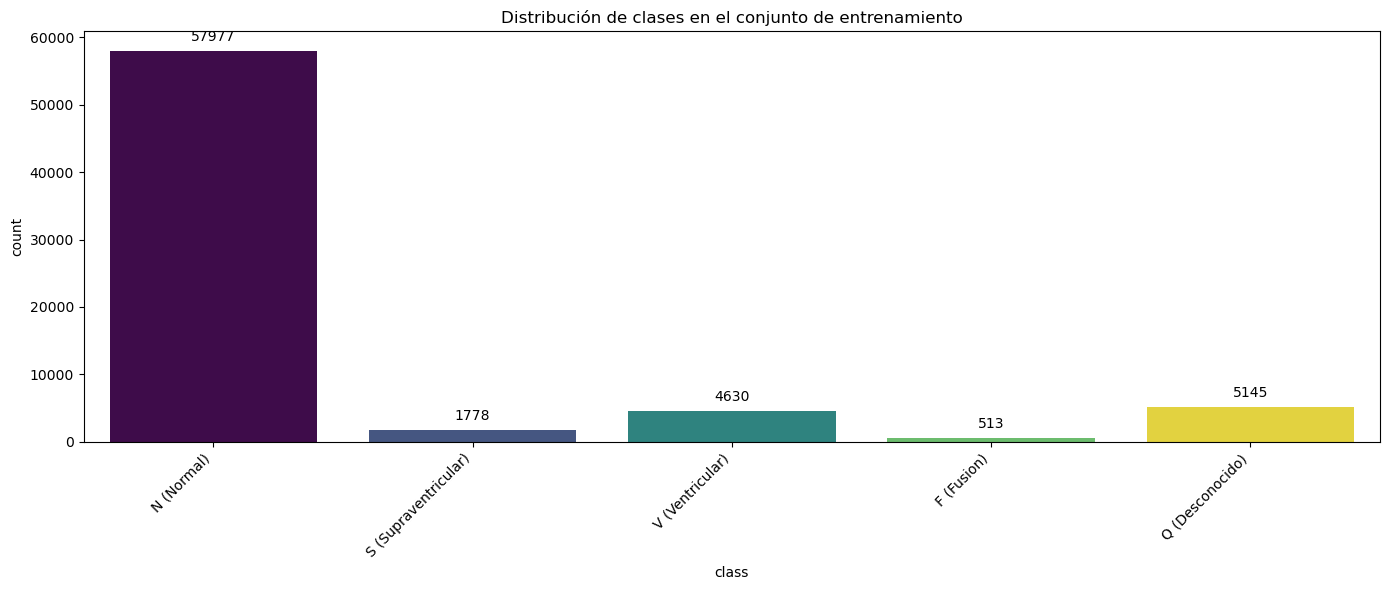

In [13]:
class_names = {0: "N (Normal)", 1: "S (Supraventricular)", 2: "V (Ventricular)", 3: "F (Fusion)", 4: "Q (Desconocido)"}
class_counts_train = train_counts.reset_index()
class_counts_train.columns = ["class", "count"]

plt.figure(figsize=(14,6))
ax = sns.barplot(data=class_counts_train, x="class", y="count", hue="class", palette="viridis", legend=False)

plt.title("Distribución de clases en el conjunto de entrenamiento")
ax.set_xticklabels([class_names[c] for c in class_counts_train["class"]])
plt.xticks(rotation=45, ha="right")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{int(height)}",
        (p.get_x() + p.get_width()/2., height),
        ha='center', va='bottom',
        fontsize=10,
        xytext=(0, 5), textcoords='offset points'
    )

plt.tight_layout()
plt.show()


#### **Ejemplos de muestras por clase**

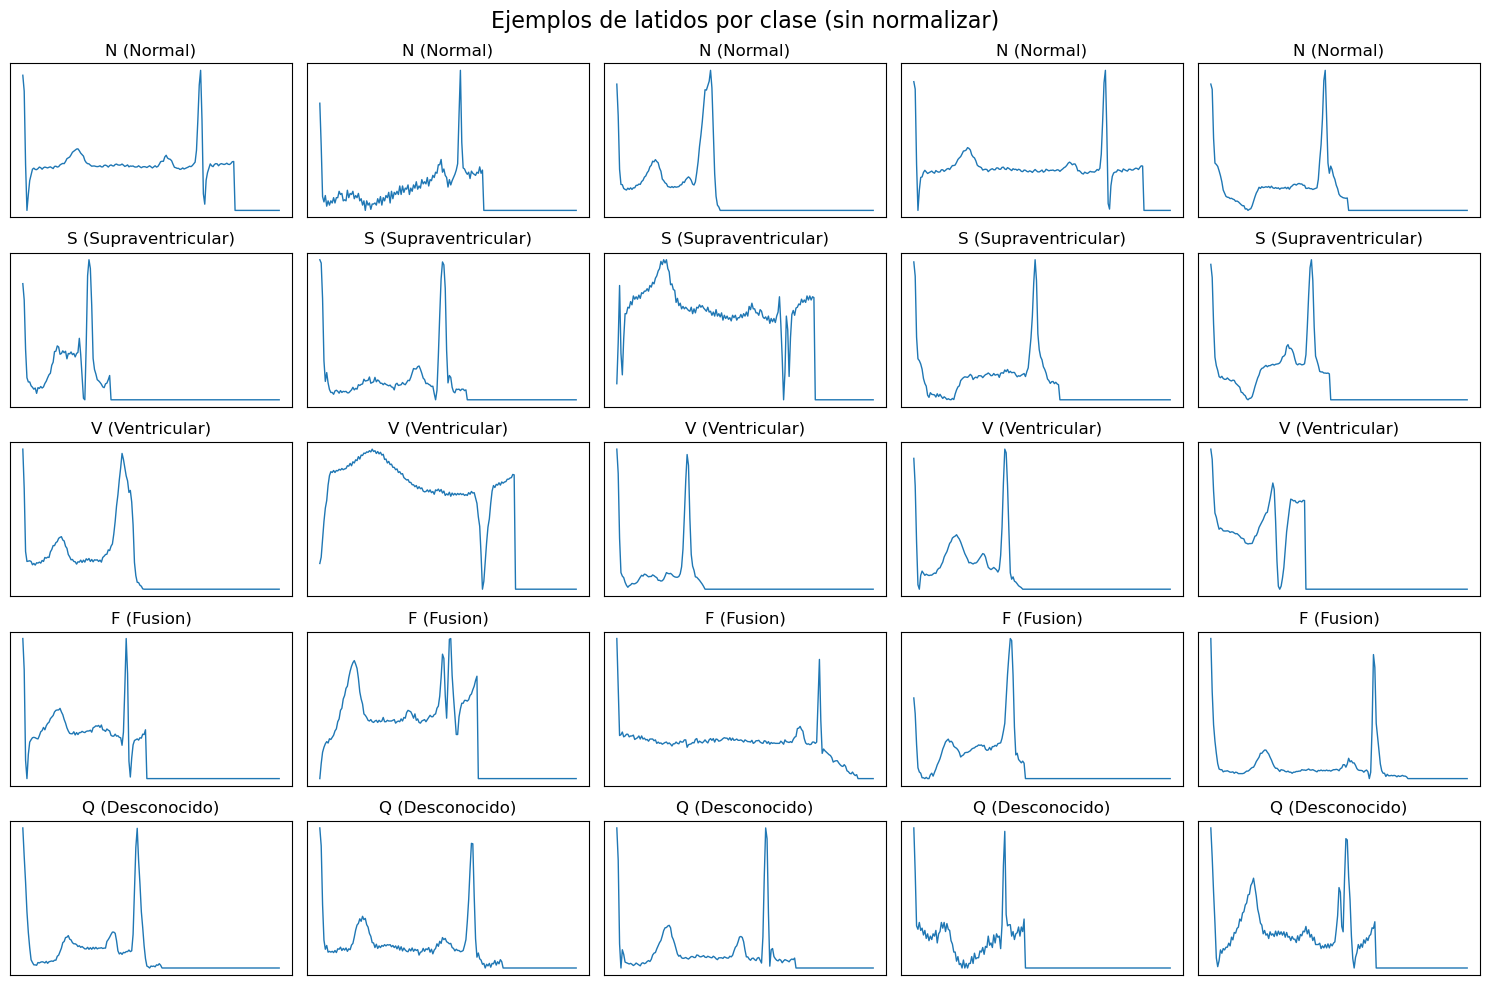

In [14]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 10), sharex=True)

for cls in range(5):
    class_indices = np.where(y_train == cls)[0]
    chosen = np.random.choice(class_indices, size=5, replace=False)

    for i, idx in enumerate(chosen):
        axes[cls, i].plot(X_train_raw[idx], linewidth=1)
        axes[cls, i].set_title(class_names[cls])
        axes[cls, i].set_xticks([])
        axes[cls, i].set_yticks([])

plt.suptitle("Ejemplos de latidos por clase (sin normalizar)", fontsize=16)
plt.tight_layout()
plt.show()


#### **Estructuras para cargado de datos**
Utilizamos Dataset y DataLoaders

In [15]:
class HeartbeatDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x = self.X[idx]
        if self.transform:
            x = self.transform(x)
        x = torch.tensor(x, dtype=torch.float32).unsqueeze(-1)
        y = torch.tensor(self.y[idx], dtype=torch.long)
        return x, y

In [ ]:
batch_size = 64

train_dataset = HeartbeatDataset(X_train, y_train)
val_dataset   = HeartbeatDataset(X_val, y_val)
test_dataset  = HeartbeatDataset(X_test_raw, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Desarrollo de Modelos

#### **GRU Estandar para primeras pruebas**

In [16]:
class stdGRU(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, num_classes=5, bidirectional=False):
        super(stdGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = 2 if bidirectional else 1
        
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional
        )
        
        self.fc = nn.Linear(hidden_size * self.num_directions, num_classes)
        
    def forward(self, x):
        out, h = self.gru(x)
        last_out = out[:, -1, :]
        logits = self.fc(last_out)
        return logits

#### **Entrenamiento**

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * x.size(0)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.detach().cpu().numpy())
        all_labels.append(y.detach().cpu().numpy())
    
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    epoch_loss = running_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")
    return epoch_loss, acc, f1


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            running_loss += loss.item() * x.size(0)
            
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.detach().cpu().numpy())
            all_labels.append(y.detach().cpu().numpy())
    
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    epoch_loss = running_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")
    return epoch_loss, acc, f1


In [20]:
num_classes = 5
model = stdGRU(input_size=1, hidden_size=64, num_layers=1, num_classes=num_classes, bidirectional=False)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 20
best_val_f1 = 0.0
best_state = None

for epoch in range(n_epochs):
    train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_f1 = evaluate(model, val_loader, criterion, device)
    
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_state = copy.deepcopy(model.state_dict())
    
    print(f"Epoch {epoch+1}/{n_epochs} "
          f"- Train Loss: {train_loss:.4f} Acc: {train_acc:.3f} F1: {train_f1:.3f} "
          f"- Val Loss: {val_loss:.4f} Acc: {val_acc:.3f} F1: {val_f1:.3f}")

# cargar mejor modelo y evaluar en test
model.load_state_dict(best_state)
test_loss, test_acc, test_f1 = evaluate(model, test_loader, criterion, device)
print(f"Test -> Loss: {test_loss:.4f} Acc: {test_acc:.3f} F1: {test_f1:.3f}")


Epoch 1/20 - Train Loss: 0.5772 Acc: 0.838 F1: 0.784 - Val Loss: 0.4080 Acc: 0.884 F1: 0.842
Epoch 2/20 - Train Loss: 0.4288 Acc: 0.879 F1: 0.842 - Val Loss: 0.3644 Acc: 0.896 F1: 0.870
Epoch 3/20 - Train Loss: 0.3028 Acc: 0.922 F1: 0.904 - Val Loss: 0.2620 Acc: 0.933 F1: 0.919
Epoch 4/20 - Train Loss: 0.2366 Acc: 0.937 F1: 0.927 - Val Loss: 0.2248 Acc: 0.942 F1: 0.937
Epoch 5/20 - Train Loss: 0.2025 Acc: 0.947 F1: 0.940 - Val Loss: 0.1869 Acc: 0.952 F1: 0.945
Epoch 6/20 - Train Loss: 0.1863 Acc: 0.950 F1: 0.944 - Val Loss: 0.1790 Acc: 0.953 F1: 0.947
Epoch 7/20 - Train Loss: 0.1744 Acc: 0.953 F1: 0.947 - Val Loss: 0.1563 Acc: 0.959 F1: 0.953


KeyboardInterrupt: 